### Preparation

In [716]:
# Configure root ..
import os
import sys
os.chdir("..")  

In [717]:
# Libraries & Packages
from src import config
import gspread
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns

pd.set_option('display.max_columns', None) 

## Import & Adjustments

In [718]:
# Import Excel files ~> TO log & Daily log
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
config.DRIVE_TP_LOG_FILENAMES

# Daily Log
daily_log_file = googleDrive_client.open(config.DRIVE_DAILY_LOG_FILENAMES[0])
daily_log_sheet = daily_log_file.get_worksheet(0)
daily_log_data = daily_log_sheet.get_all_values()
daily_log_df = pd.DataFrame(daily_log_data[1:], columns=daily_log_data[0]) 

# TP Log
tp_log_file = googleDrive_client.open(config.DRIVE_TP_LOG_FILENAMES[0])
tp_log_sheet = tp_log_file.get_worksheet(0)
tp_log_data = tp_log_sheet.get_all_values()
tp_log_df = pd.DataFrame(tp_log_data[1:], columns=tp_log_data[0]) 

In [719]:
# Small adjustments

# Convert to numeric (all are object ...)
def safe_convert(x):
    if x == "":
        return np.nan  # Treat empty strings as NaN
    try:
        return pd.to_numeric(x)
    except (ValueError, TypeError):
        return str(x)
    
for data in [daily_log_df, tp_log_df]:
    for col in data.columns:
        try:
            data[col] = data[col].apply(safe_convert)
        except ValueError:
            pass 

# Date & Datetime
daily_log_df["Date"] = pd.to_datetime(daily_log_df[["Year", "Month", "Day"]]).dt.date
tp_log_df["Date"] = pd.to_datetime(tp_log_df[["Year", "Month", "Day"]]).dt.date
daily_log_df["Datetime"] = pd.to_datetime(daily_log_df[["Year", "Month", "Day"]])
tp_log_df["Datetime"] = pd.to_datetime(tp_log_df[["Year", "Month", "Day"]])

# Sort by date
daily_log_df = daily_log_df.sort_values(by="Date").reset_index(drop=True)
tp_log_df = tp_log_df.sort_values(by="Date").reset_index(drop=True)

# Some conversions
tp_log_df["Activity type"] = tp_log_df["Activity type"].replace({"Cycling": "Road Biking"}) #  Convert Cycling to Road Biking in Activity type
tp_log_df["Activity type"] = tp_log_df["Activity type"].str.replace("Cycling", "Biking") # cycling to biking in Activity type

In [720]:
# Data check

print("Daily Log:")
print("-------------------------------------")
print("Date range: {} to {}".format(daily_log_df["Date"].min(), daily_log_df["Date"].max()))
print("Duplicated rows = {}".format(daily_log_df[daily_log_df.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_log_df["Date"].min(), end=daily_log_df["Date"].max()).date if d not in daily_log_df["Date"].values]))


print("\nTraining Log:")
print("-------------------------------------")
print("Date range: {} to {}".format(tp_log_df["Date"].min(), tp_log_df["Date"].max()))
print("Duplicated rows = {}".format(tp_log_df[tp_log_df.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=tp_log_df["Date"].min(), end=tp_log_df["Date"].max()).date if d not in tp_log_df["Date"].values]))

Daily Log:
-------------------------------------
Date range: 2024-09-13 to 2025-08-16
Duplicated rows = 0
Missing dates = []

Training Log:
-------------------------------------
Date range: 2024-09-13 to 2025-08-16
Duplicated rows = 0
Missing dates = []


## Work on data

In [ ]:
# Work!

# Normalized HRV values (-inf, inf) ~> Upper bound = 1, Lower bound = 0 ~> Lower = better
daily_log_df["HRV normalized"] = (daily_log_df["HRV"] - daily_log_df["HRV baseline lower"]) / (daily_log_df["HRV baseline upper"] - daily_log_df["HRV baseline lower"])

# Races
tp_log_df["Description"] = np.where(tp_log_df["Description"].str.contains("Race"), "Race", tp_log_df["Description"])  

# Performance vs. effor ~> Heart rate vs. Gradient adjusted pace
# --> "Running efficiency index (EF)" = Gradient adjusted pace / Average heart rate
def EF_formula(avg_pace, avg_hr):
    if avg_hr == 0:
        return np.nan 
    return avg_pace / avg_hr

# Normalization of heart rate
# 1. % Of maximum heart rate [max HR = 190 bpm]
# 2. % Of heart rate reserve [max HR = 190 bpm] [Resting HR = average from last 31 days]
max_heart_rate = 190
resting_heart_rate = daily_log_df["Resting HR"].iloc[-31:-1].mean()
for col in tp_log_df.columns[tp_log_df.columns.str.lower().str.contains("heart rate")].values:
    tp_log_df[col + " [normalized ~ max]"] = tp_log_df[col] / max_heart_rate
    tp_log_df[col + " [normalized ~ HRR]"] = (tp_log_df[col] - resting_heart_rate) / (max_heart_rate - resting_heart_rate)

# Normalization of distance
# Mean ~> Reflects usual training
# Max recent distance ~> Reflects what your body recently tolerated
# Normalized distance = [Today’s Distance]​ / [Chronic Avg+α(Recent Max−Chronic Avg)]

## Quick Analysis

#### Training log

In [722]:
# Quick analyis ~ Training log

print("Different activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    tp_log_df
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours, ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Different activities and their counts:
-------------------------------------
Trail Running ~> 272.32 hours, (146 act.)
Road Biking ~> 84.39 hours, (35 act.)
Running ~> 78.25 hours, (76 act.)
Indoor Biking ~> 71.04 hours, (51 act.)
Hiking ~> 15.35 hours, (6 act.)
Mountain Biking ~> 12.67 hours, (7 act.)
Lap Swimming ~> 0.21 hours, (1 act.)


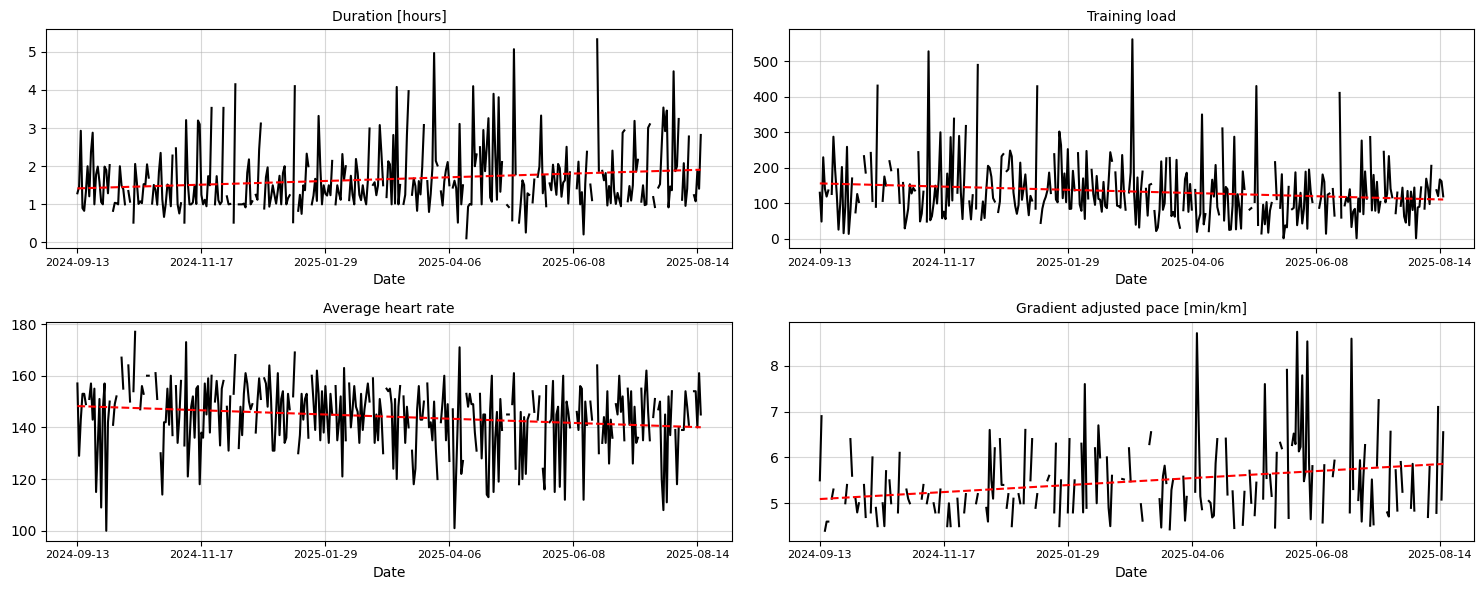

In [723]:
# Some Training log trends

fig, ax = plt.subplots(2, 2, figsize=(15, 6))
indices = np.arange(0, len(tp_log_df["Datetime"]))

ax[0,0].set_title("Duration [hours]", fontsize=10)
ax[0,0].plot(indices, tp_log_df["Duration [h]"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Duration [h]"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,0])

ax[0,1].set_title("Training load", fontsize=10)
ax[0,1].plot(indices, tp_log_df["Training load"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Training load"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,1])

ax[1,0].set_title("Average heart rate", fontsize=10)
ax[1,0].plot(indices, tp_log_df["Average heart rate"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Average heart rate"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,0])

ax[1,1].set_title("Gradient adjusted pace [min/km]", fontsize=10)
ax[1,1].plot(indices, tp_log_df["Gradient adjusted pace [min/km]"], label="VO2max", color="black")
sns.regplot(x=indices, y=tp_log_df["Gradient adjusted pace [min/km]"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,1])

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(indices[::max(1, len(indices)//5)])  
        ax[i,j].set_xticklabels(tp_log_df["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
        ax[i,j].set_xlabel("Date")
        ax[i,j].set_ylabel("")
        ax[i,j].grid(alpha=.5)

plt.tight_layout()
plt.show()

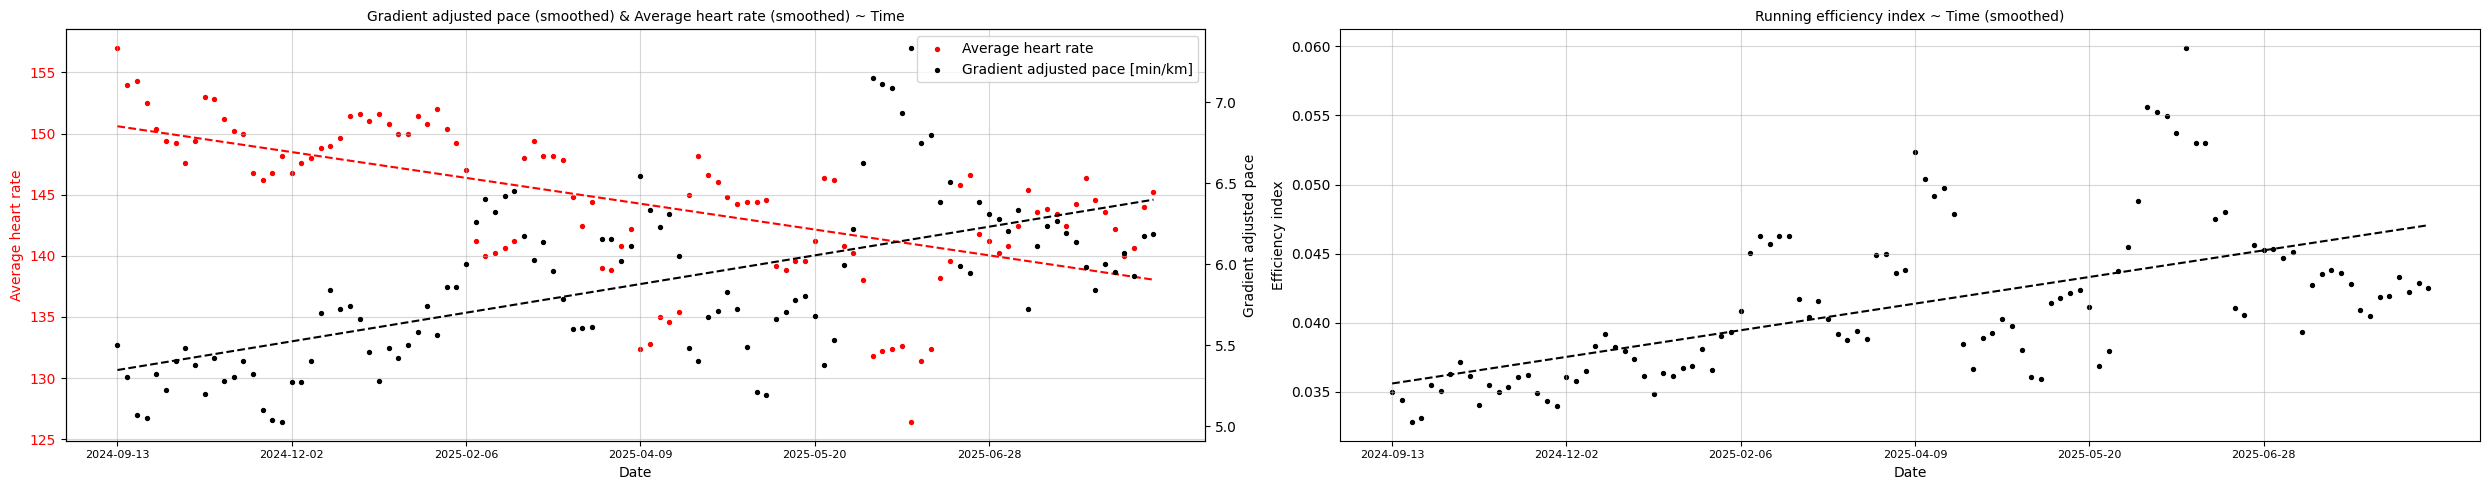

In [724]:
# Aerobic runs ~ Relationship between Gradient adjusted pace & Average heart rate 

# Prepare ~> Also some races are in ...
aerobic_runs = (
    tp_log_df
    .query("`Activity type` in (['Trail Running', 'Running'])") # Trail running
    .query("`Description`.str.contains('Running')") # Normal runs ~ No specific training (aerobic runs)
    .query("Description != 'Race'") # Remove races
    )

aerobic_runs["Gradient adjusted pace [min/km] smoothed"] = aerobic_runs["Gradient adjusted pace [min/km]"].rolling(window=5, min_periods=1).mean()
aerobic_runs["Average heart rate smoothed"] = aerobic_runs["Average heart rate"].rolling(window=5, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(1,2, figsize=(25, 5))
indices = np.arange(0, len(aerobic_runs["Datetime"]))

# Plot 1
ax[0].set_title("Gradient adjusted pace (smoothed) & Average heart rate (smoothed) ~ Time", fontsize=10)
ax[0].scatter(indices, aerobic_runs["Average heart rate smoothed"], label="Average heart rate", color="red", s=8)
sns.regplot(x=indices, y=aerobic_runs["Average heart rate smoothed"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0])
ax[0].set_ylabel("Average heart rate", color="red")
ax[0].tick_params(axis="y", labelcolor="red")

ax1 = ax[0].twinx()
ax1.scatter(indices, aerobic_runs["Gradient adjusted pace [min/km] smoothed"], label="Gradient adjusted pace [min/km]", color="black", s=8)
sns.regplot(x=indices, y=aerobic_runs["Gradient adjusted pace [min/km] smoothed"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax1)
ax1.set_ylabel("Gradient adjusted pace", color="black")
ax1.tick_params(axis="y", labelcolor="black")

handles1, labels1 = ax[0].get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

# Plot 2 ~> Running efficiency index
aerobic_runs["EF"] = aerobic_runs.apply(lambda row: EF_formula(row["Gradient adjusted pace [min/km]"], row["Average heart rate"]), axis=1)
aerobic_runs["EF smoothed"] = aerobic_runs["EF"].rolling(window=5, min_periods=1).mean()

ax[1].set_title("Running efficiency index ~ Time (smoothed)", fontsize=10)
ax[1].scatter(indices, aerobic_runs["EF smoothed"], color="black", s=8)
sns.regplot(x=indices, y=aerobic_runs["EF smoothed"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1])
ax[1].set_ylabel("Efficiency index", color="black")

for i in [0,1]:
    ax[i].set_xticks(indices[::max(1, len(indices)//6)])  
    ax[i].set_xticklabels(aerobic_runs["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//6)], fontsize=8, rotation=0)
    ax[i].set_xlabel("Date")
    ax[i].grid(alpha=.5)

plt.tight_layout()
plt.show()

#### Daily log

In [725]:
# Quick analyis ~ Daily log
print("Current performance values:")
print("-------------------------------------")
print("VO2max ~> {:.2f} ml/kg/min".format(daily_log_df["vo2Max"].iloc[-1]))
print("Hill score ~> {}".format(daily_log_df["Hill score"].iloc[-1]))
print("Endurance score ~> {}".format(daily_log_df["Endurance score"].iloc[-1]))
print("Normalized HRV ~> {:.2f}".format(daily_log_df["HRV normalized"].iloc[-1]))

Current performance values:
-------------------------------------
VO2max ~> 60.20 ml/kg/min
Hill score ~> 94
Endurance score ~> 8670
Normalized HRV ~> 0.12


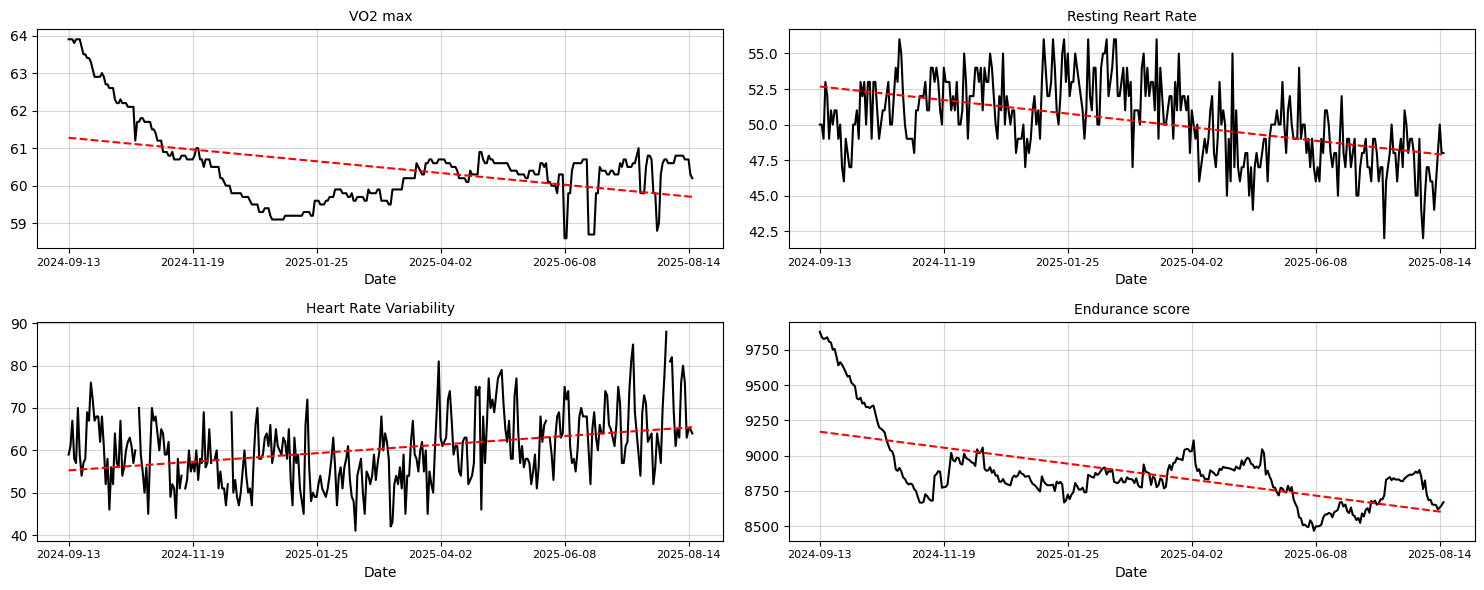

In [726]:
# Some Daily log trends
fig, ax = plt.subplots(2, 2, figsize=(15, 6))
indices = np.arange(0, len(daily_log_df["Datetime"]))

ax[0,0].set_title("VO2 max", fontsize=10)
ax[0,0].plot(indices, daily_log_df["vo2Max"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["vo2Max"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,0])

ax[0,1].set_title("Resting Reart Rate", fontsize=10)
ax[0,1].plot(indices, daily_log_df["Resting HR"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["Resting HR"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0,1])

ax[1,0].set_title("Heart Rate Variability", fontsize=10)
ax[1,0].plot(indices, daily_log_df["HRV"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["HRV"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,0])

ax[1,1].set_title("Endurance score", fontsize=10)
ax[1,1].plot(indices, daily_log_df["Endurance score"], label="VO2max", color="black")
sns.regplot(x=indices, y=daily_log_df["Endurance score"], color="red", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1,1])

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(indices[::max(1, len(indices)//5)])  
        ax[i,j].set_xticklabels(daily_log_df["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
        ax[i,j].set_xlabel("Date")
        ax[i,j].set_ylabel("")
        ax[i,j].grid(alpha=.5)

plt.tight_layout()
plt.show()

#### Training log & Daily log

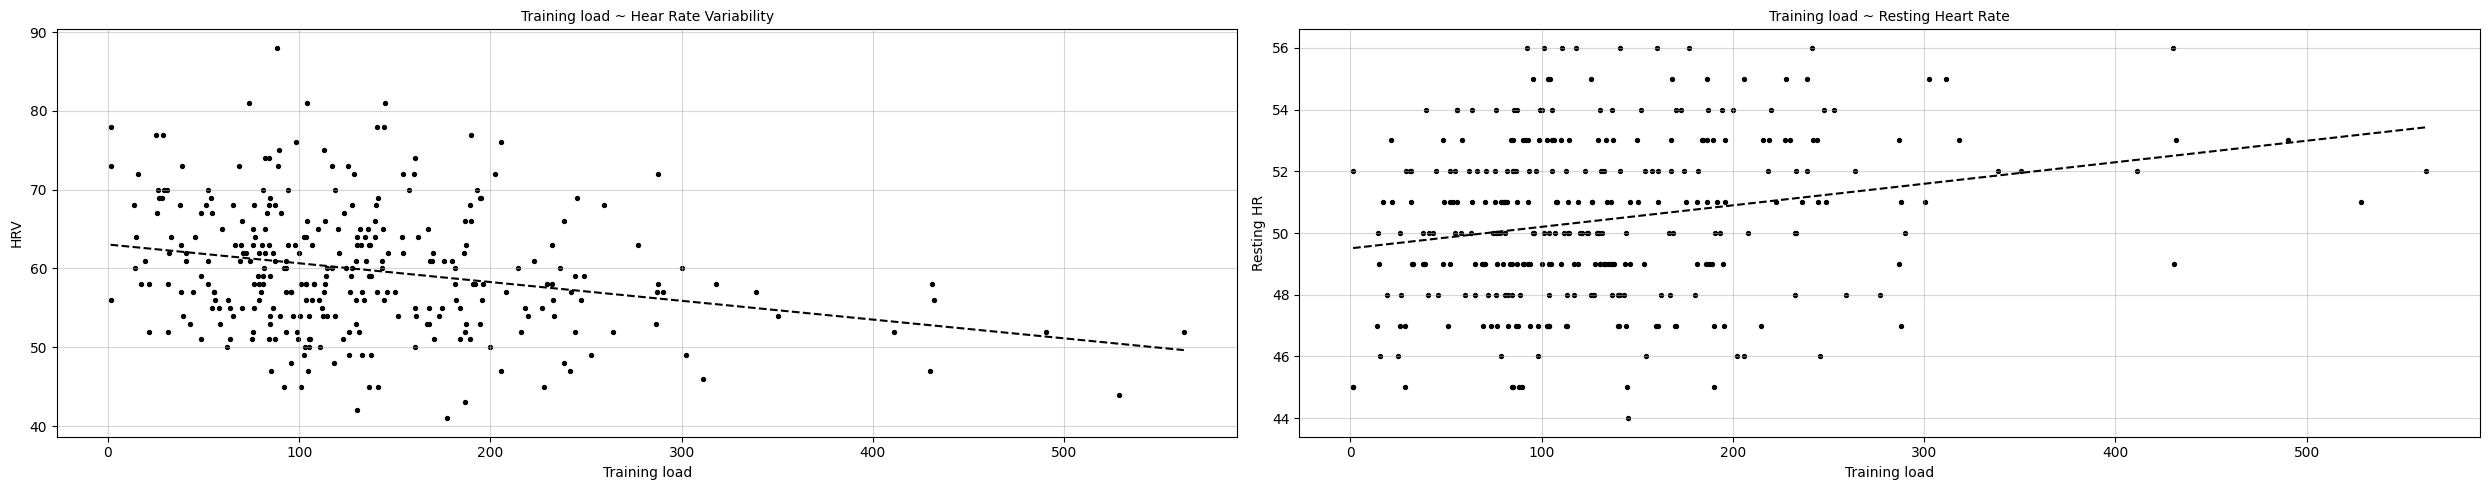

In [727]:
# Effect on hard training days on next days HRV and Resting HR


# Prepare
next_day_effect = (
    tp_log_df
    # Hard trainingy days ~> Aerobic >= 3.5 or Anaerobic
    .assign(hard_training_day = lambda df: (df["Aerobic training effect"] >= 3.5) | (df["Training effect label"].isin(['Tempo', 'Vo2max', 'Lactate threshold', 'Anaerobic capacity'])))
    [["Date", "Aerobic training effect", "Anaerobic training effect", "Training effect label", "Training load", "hard_training_day"]]
    .merge(
        daily_log_df[["Date", "HRV", "Resting HR"]]
        .assign(MergeDate = lambda df: df["Date"] + datetime.timedelta(days=-1))
        .drop(columns=["Date"]),
        left_on = "Date", right_on = "MergeDate", how="left"
    )
    .drop(columns=["Date", "MergeDate"])
    )

# Plot
fig, ax = plt.subplots(1,2, figsize=(25, 5))

ax[0].set_title("Training load ~ Hear Rate Variability", fontsize=10)
ax[0].scatter(next_day_effect["Training load"], next_day_effect["HRV"], color="black", s=8)
sns.regplot(x=next_day_effect["Training load"], y=next_day_effect["HRV"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[0])
ax[0].set_ylabel("HRV")

ax[1].set_title("Training load ~ Resting Heart Rate", fontsize=10)
ax[1].scatter(next_day_effect["Training load"], next_day_effect["Resting HR"], color="black", s=8)
sns.regplot(x=next_day_effect["Training load"], y=next_day_effect["Resting HR"], color="black", line_kws={"linestyle":"--", "linewidth":1.5}, ci=None, scatter=False, ax=ax[1])
ax[1].set_ylabel("Resting HR")

for i in [0,1]:
    ax[i].set_xlabel("Training load")
    ax[i].grid(alpha=.5)

plt.tight_layout()
plt.show()

#### Simple Timelapses

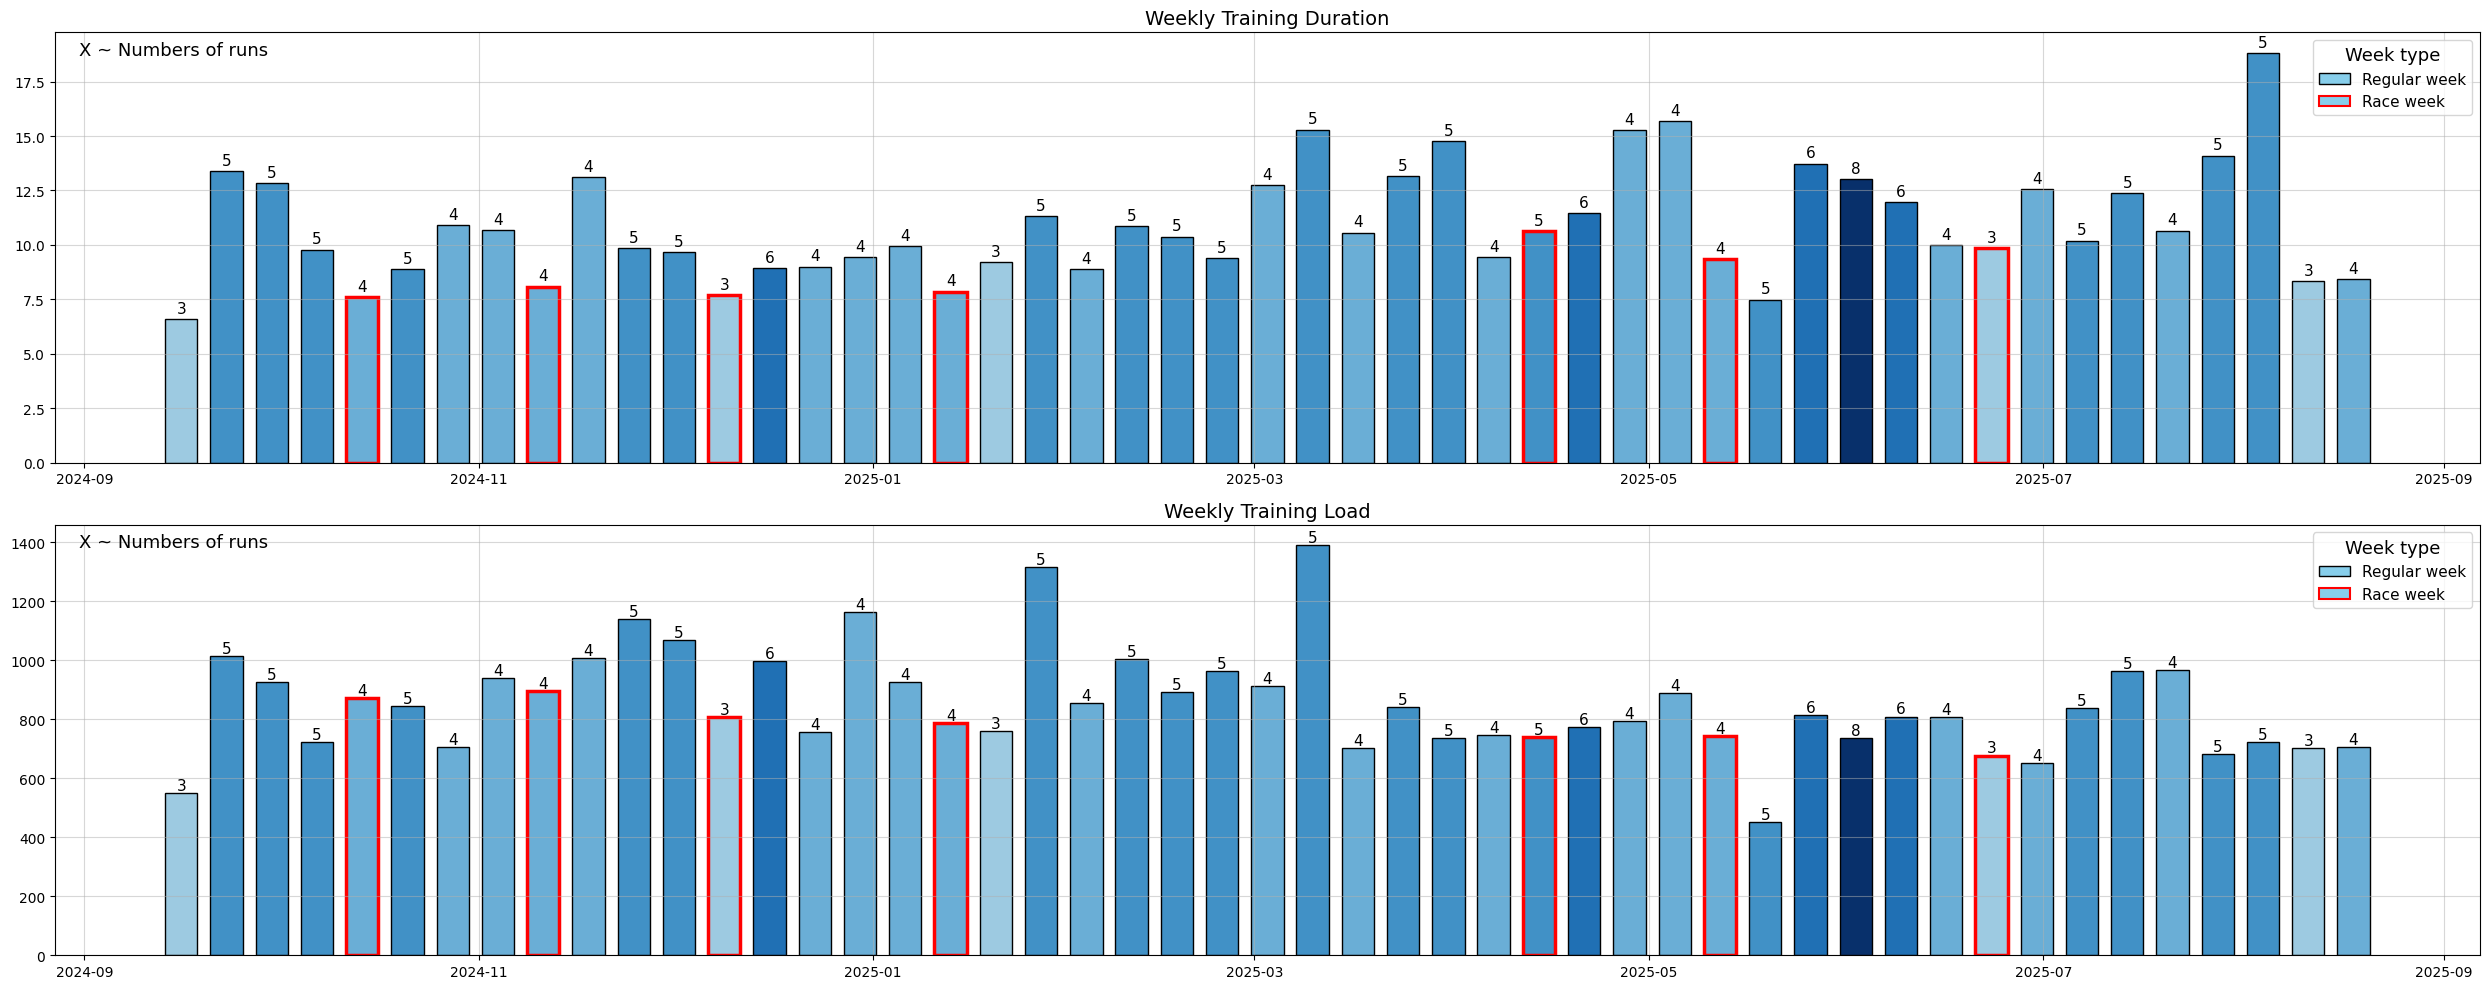

In [728]:
# Weekly ...
weekly_time_hr = (
    tp_log_df
    .groupby(pd.Grouper(key="Datetime", freq="W-Mon"))
    .agg(
        total_duration=("Duration [h]", "sum"),
        total_load=("Training load", "sum"),
        nr_runs=("Activity type", lambda x: (x == "Running").sum() + (x == "Trail Running").sum() if isinstance(x, pd.Series) else 0),
        race=("Description", lambda x: 1 if (x == "Race").any() else 0)
    )
    .reset_index()
)

fig, ax = plt.subplots(2,1, figsize=(25, 10))

# Color by number of runs
norm = mcolors.Normalize(vmin=0, vmax=weekly_time_hr["nr_runs"].max() / 7)
colors = cm.Blues(norm(weekly_time_hr["nr_runs"] / 7))

# Races ~ edge
edge_colors = ["red" if r == 1 else "black" for r in weekly_time_hr["race"]]
edge_widths = [2.5 if r == 1 else 1.0 for r in weekly_time_hr["race"]]

# Plot total weekly duration
ax[0].set_title("Weekly Training Duration", fontsize=14)
bars_duration = ax[0].bar(weekly_time_hr["Datetime"], weekly_time_hr["total_duration"], width=5, color=colors, edgecolor=edge_colors, linewidth=edge_widths)

for bar, runs in zip(bars_duration, weekly_time_hr["nr_runs"]):
    ax[0].text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.15, str(runs),                          
        ha="center", va="bottom", fontsize=11, color="black"
    )

# Plot total weekly load
ax[1].set_title("Weekly Training Load", fontsize=14)
bars_load = ax[1].bar(weekly_time_hr["Datetime"], weekly_time_hr["total_load"], width=5, color=colors, edgecolor=edge_colors, linewidth=edge_widths)

for bar, runs in zip(bars_load, weekly_time_hr["nr_runs"]):
    ax[1].text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.15, str(runs),                          
        ha="center", va="bottom", fontsize=11, color="black"
    )

# Legend
week_type_legend  = [
    mpatches.Patch(facecolor="skyblue", edgecolor="black", label="Regular week"),
    mpatches.Patch(facecolor="skyblue", edgecolor="red", linewidth=1.5, label="Race week")
]

for i in [0,1]:
    ax[i].grid(alpha=.5)
    ax[i].legend(handles=week_type_legend, title="Week type", fontsize=11, title_fontsize=13)
    ax[i].text(0.01, 0.98, "X ~ Numbers of runs", transform=ax[i].transAxes, fontsize=13, va="top")

plt.tight_layout()
plt.show()

---
---
## Training load
Training Load is not a simple metric you calculate from one formula. Each platform has its own implementation. But they are all based on the same principle. Training Load = the physiological stress of a workout, usually derived from heart rate, power, or pace, weighted by intensity and duration.

1. Garmin’s Training Load: Excess Post-Exercise Oxygen Consumption (EPOC) estimate.
- EPOC is how much extra oxygen your body needs to recover after exercise, and it’s strongly related to exercise intensity (HR vs. VO2Max).
- So Garmin computes Training Load by:
    - Estimating your oxygen consumption (VO2) from HR and VO2Max.
    - Integrating the excess oxygen above baseline over the session → gives EPOC.
    - Expressing that as a number (typically 0–1000 per workout; daily/weekly totals can be higher).

2. TrainingPeaks (TSS – Training Stress Score): In cycling/running science, the most used is TSS (Training Stress Score):
- TSS=(Duration * NormalizedPower * IF) / (FTP * 3600) * ×100
- Duration = in seconds
- Normalized Power (NP) = weighted power that accounts for variability
- IF (Intensity Factor) = NP / FTP
- FTP = Functional Threshold Power

3. Polar & Others
- Polar calls it Cardio Load, also based on HR -> TRIMP (Training Impulse).
- TRIMP = Duration * Relative HR intensity * e^(k * Relative HR intensity)
- Relative HR intensity: (HR avg - HR rest) / (HR max - HR rest)
- k = gender constant (men = 1.92, women = 1.67)

4. Zone-based TRIMP
- TRIMP = SUM[TimeInZone(i) * WeightZone(i)]
- ZoneWeifgr = 1-5 or exponential weights.


There is no absolute “true” training load value. Garmin’s Training Load is itself just a model/estimate of physiological strain (based on their EPOC algorithm). So you’re right: you can’t really say “my load is better than Garmin’s” in an absolute sense unless you have some external ground truth to compare against. What could be a “ground truth”? In sports science, training load is usually validated against outcomes, not against another black-box metric. Examples: Recovery/fatigue markers: next-day resting HR, HRV, sleep quality. Performance metrics: race times, FTP/VO2Max trends, pace at given HR. Subjective ratings: RPE (Rate of Perceived Exertion), “how hard did it feel?”. So instead of asking “is my metric better than Garmin’s?”, a more useful question is: Which training load metric (Garmin’s, TRIMP, my ML model) correlates more strongly with recovery and performance outcomes?

Bottom line: Garmin’s load is not the truth → it’s just one proprietary model. Your metric could be just as valid if it aligns better with recovery/performance. The real test: How well does each metric explain or predict how your body responds to training?

##### Explain Garmins Training Load
---

In [729]:
# Help functions ~ Univariate Linear Regression for Training load analysis

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

training_load_data = (
    tp_log_df
    .query("`Activity type` in (['Trail Running', 'Running'])") 
    .copy()
    )

training_load_univariate_df = pd.DataFrame()
def univariate_LM_training_load_analysis(feature_col, data=training_load_data):

    print("-----------------------------------------------------")
    print(feature_col.upper(), " ~> Training load Univariate Linear Regression")
    print("-----------------------------------------------------\n")

    # Modeling ~> Linear regression
    data_clean = data[[feature_col, "Training load"]].dropna() 
    X = sm.add_constant(data_clean[[feature_col]])
    y = data_clean["Training load"]

    model = sm.OLS(y, X)
    fit = model.fit()
    y_pred = fit.predict(X)

    # Metrics
    metrics = {
        "coef": fit.params[feature_col],
        "scaled coef": fit.params[feature_col] / np.std(data_clean[feature_col]),
        "p-value": fit.pvalues[feature_col],
        "standard error": fit.bse[feature_col],
        "scaled standard error": fit.bse[feature_col] / np.std(data_clean[feature_col]),
        "confidence interval": round(fit.conf_int().loc[feature_col], 4).tolist(),
        "scaled confidence interval": round(fit.conf_int().loc[feature_col] / np.std(data_clean[feature_col]), 4).tolist(),
        "R2": fit.rsquared,
        "R2 adjusted": fit.rsquared_adj,
        "MAE": mean_absolute_error(y, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
        "Pearson correlation coefficient": pearsonr(data_clean[feature_col], data_clean["Training load"])[0]
    }

    
    metrics_df = pd.DataFrame([metrics])
    metrics_df.insert(0, "feature", feature_col)

    for key, value in metrics.items():
        if isinstance(value, list):
            print(f"{key} ~> {[f'{v:.4f}' for v in value]}")
        else:
            print(f"{key} ~> {value:.4f}" if isinstance(value, float) else f"{key} ~> {value}")

    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(25, 10))

    # Feature distribution
    ax[0,0].hist(data_clean[feature_col], bins=30, density=True, color="grey", edgecolor="black", alpha=1.0)
    sns.kdeplot(data_clean[feature_col], ax=ax[0,0], color="black", linewidth=2)
    ax[0,0].set_xlabel(feature_col)

    # Scatter plot with regression line
    ax[0,1].scatter(data_clean[feature_col], y, color="black", s=15, alpha=.6)
    sns.regplot(x=data_clean[feature_col], y=y, ax=ax[0,1], scatter=False, line_kws={"color":"red", "linewidth":2})
    ax[0,1].set_xlabel(feature_col)
    ax[0,1].set_ylabel("Training load")
    ax[0,1].set_title(f"{feature_col} vs Training load")

    # Residuals scatter ~ Linearity assumption, Homoscedasticity, Outliers, Centering around zero
    residuals = y - y_pred
    ax[1,0].scatter(y_pred, residuals, color="black", s=15, alpha=.6)
    ax[1,0].axhline(0, color="red", linestyle="--")
    ax[1,0].set_xlabel("Predicted Training load")
    ax[1,0].set_ylabel("Residuals")
    ax[1,0].set_title(f"Residuals vs Predicted for {feature_col}")

    # Residuals KDE ~ Normality assumption
    ax[1,1].hist(residuals, bins=30, density=True, color="grey", edgecolor="black", alpha=1.0)
    sns.kdeplot(residuals, ax=ax[1,1], color="black", linewidth=2)
    ax[1,1].set_title(f"Residuals Distribution for {feature_col}")
    ax[1,1].set_xlabel("Residuals")
    ax[1,1].set_ylabel("Density")

    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid(alpha=.5)

    plt.tight_layout()
    plt.show()


    return metrics_df

-----------------------------------------------------
DURATION [H]  ~> Training load Univariate Linear Regression
-----------------------------------------------------

coef ~> 53.1943
scaled coef ~> 62.6825
p-value ~> 0.0000
standard error ~> 5.5202
scaled standard error ~> 6.5049
confidence interval ~> ['42.3150', '64.0736']
scaled confidence interval ~> ['49.8627', '75.5024']
R2 ~> 0.2968
R2 adjusted ~> 0.2936
MAE ~> 52.8635
RMSE ~> 69.4846
Pearson correlation coefficient ~> 0.5448


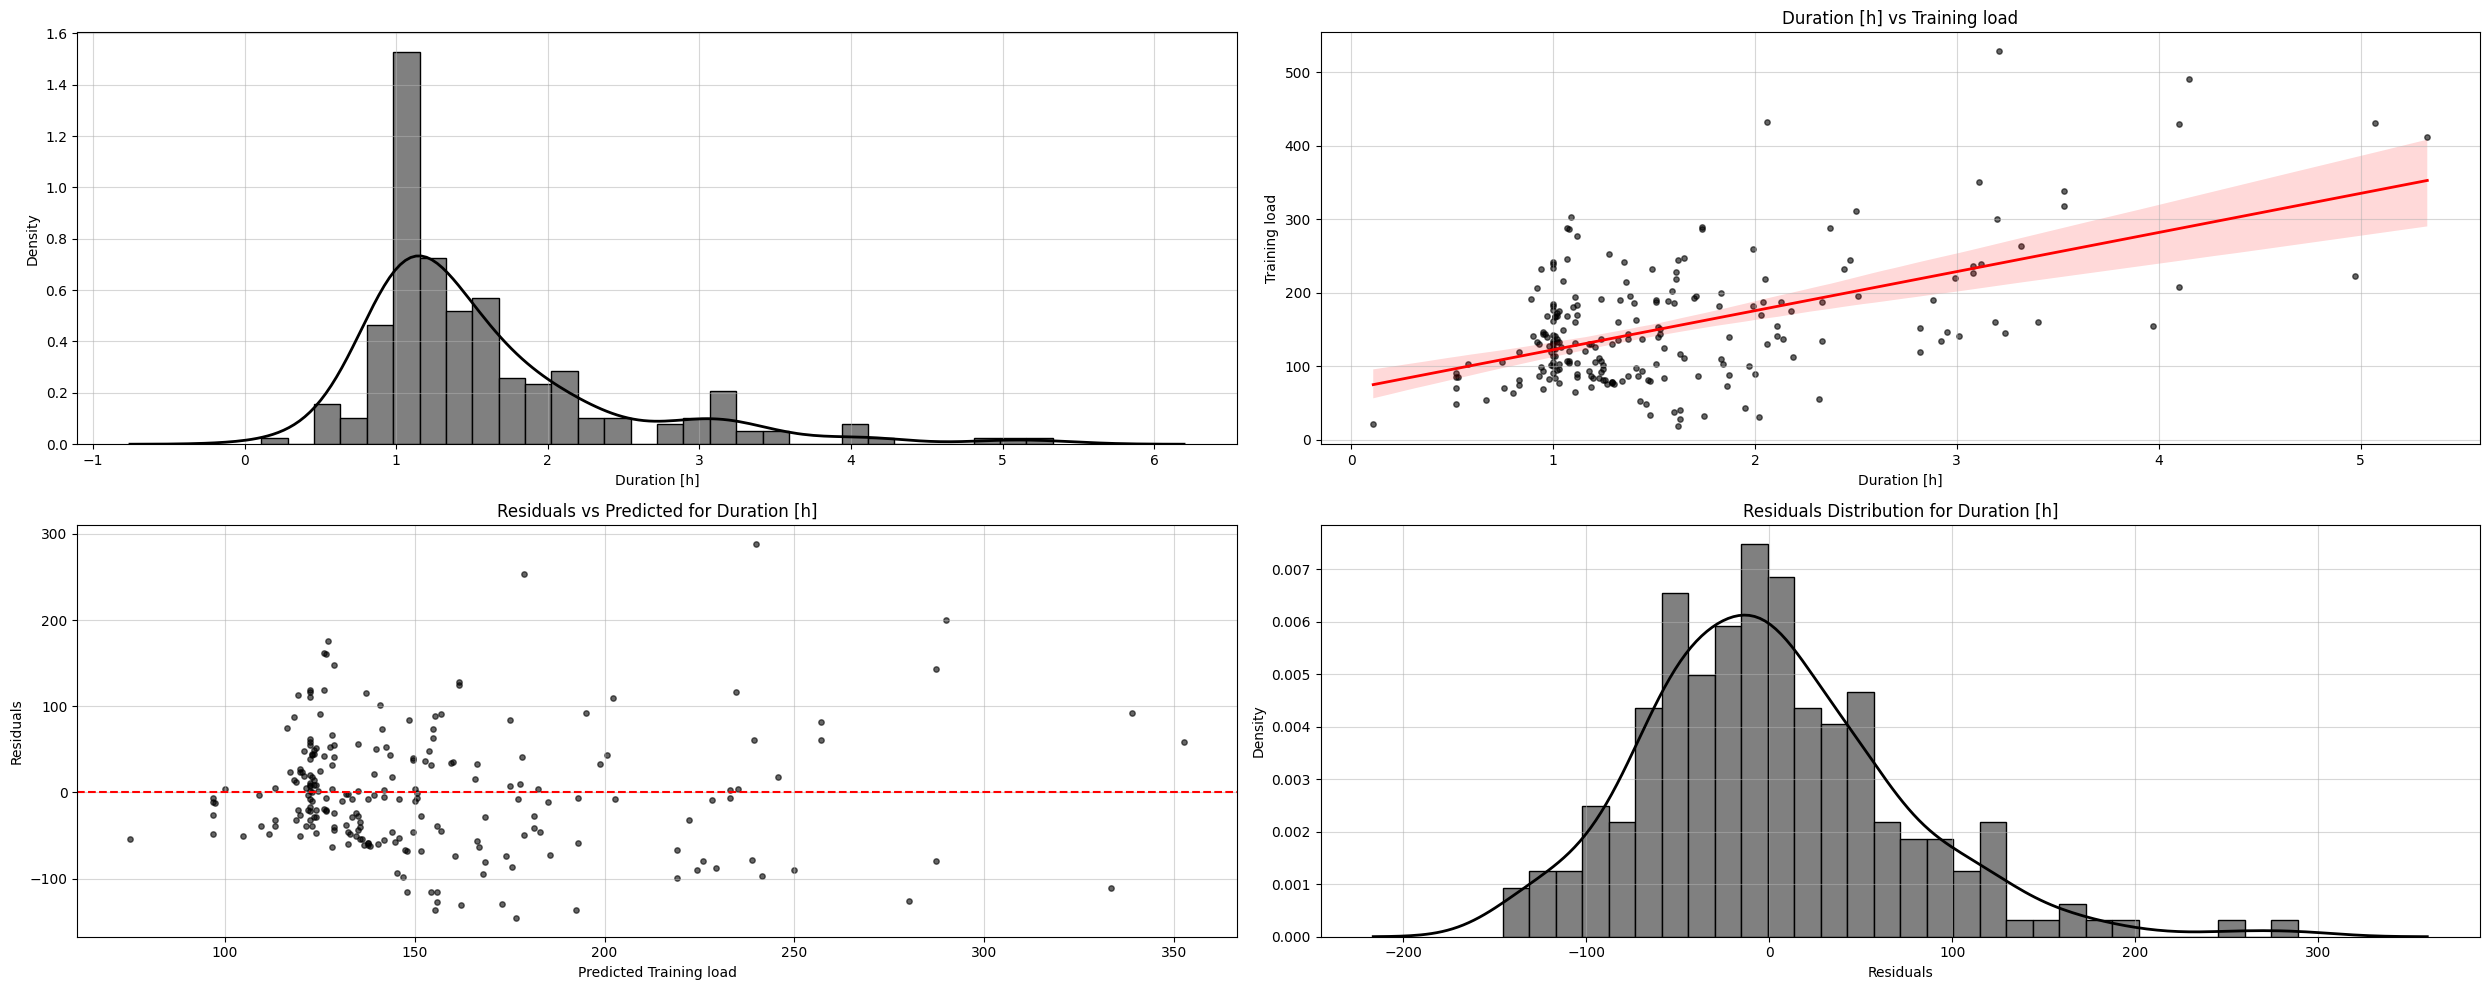

In [730]:
# Duration [h]
metrics_tmp = univariate_LM_training_load_analysis(feature_col="Duration [h]")
training_load_univariate_df = pd.concat([training_load_univariate_df, metrics_tmp], ignore_index=True)

-----------------------------------------------------
DISTANCE [KM]  ~> Training load Univariate Linear Regression
-----------------------------------------------------

coef ~> 9.3860
scaled coef ~> 1.4090
p-value ~> 0.0000
standard error ~> 0.5503
scaled standard error ~> 0.0826
confidence interval ~> ['8.3015', '10.4706']
scaled confidence interval ~> ['1.2462', '1.5718']
R2 ~> 0.5694
R2 adjusted ~> 0.5674
MAE ~> 40.5168
RMSE ~> 54.3732
Pearson correlation coefficient ~> 0.7546


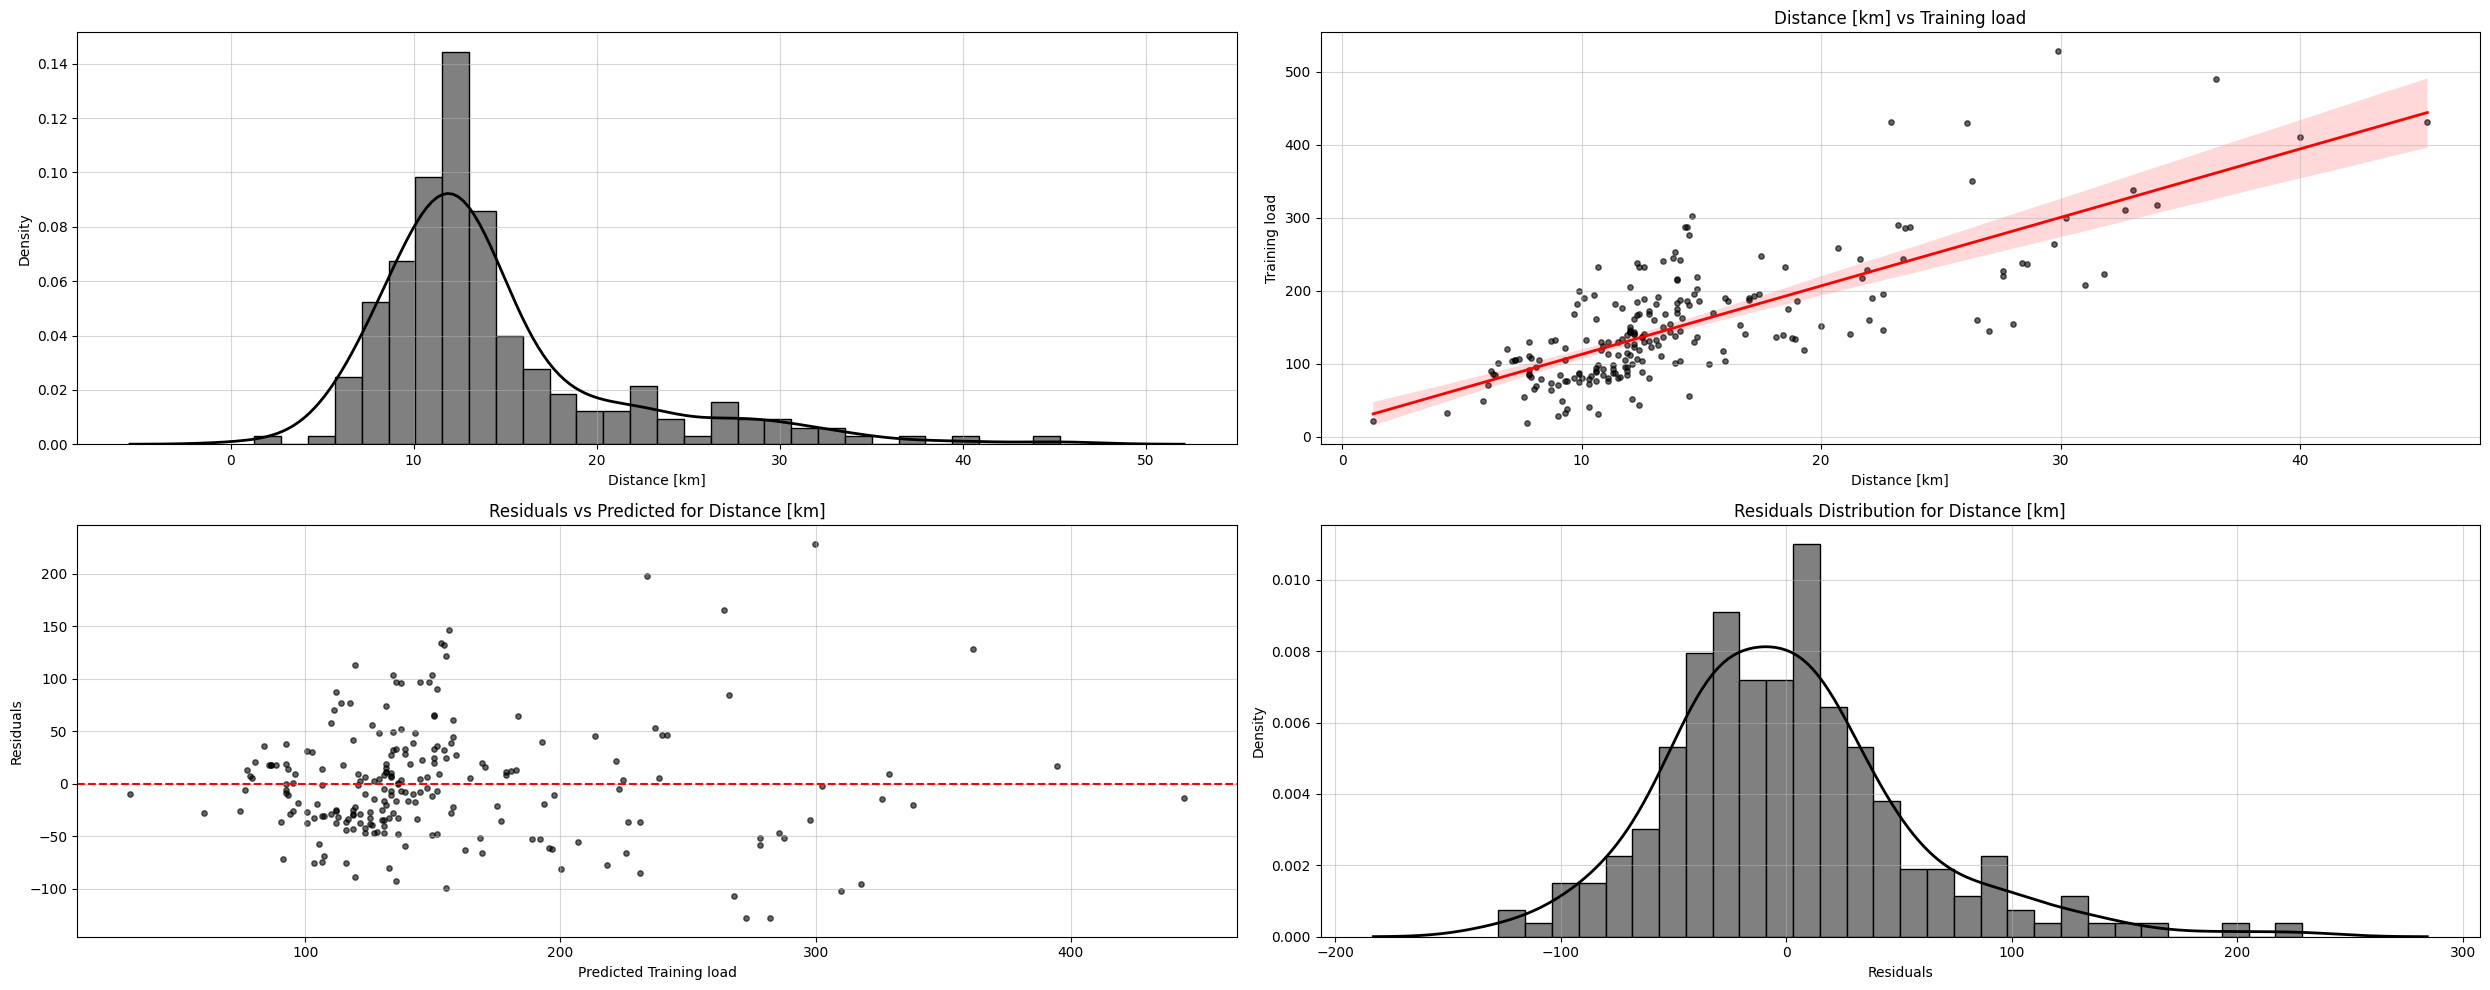

In [731]:
# Distance [km]
metrics_tmp = univariate_LM_training_load_analysis(feature_col="Distance [km]")
training_load_univariate_df = pd.concat([training_load_univariate_df, metrics_tmp], ignore_index=True)

-----------------------------------------------------
AVERAGE HEART RATE  ~> Training load Univariate Linear Regression
-----------------------------------------------------

coef ~> 6.0653
scaled coef ~> 0.6027
p-value ~> 0.0000
standard error ~> 0.3754
scaled standard error ~> 0.0373
confidence interval ~> ['5.3255', '6.8051']
scaled confidence interval ~> ['0.5292', '0.6762']
R2 ~> 0.5427
R2 adjusted ~> 0.5406
MAE ~> 41.4954
RMSE ~> 56.0335
Pearson correlation coefficient ~> 0.7367


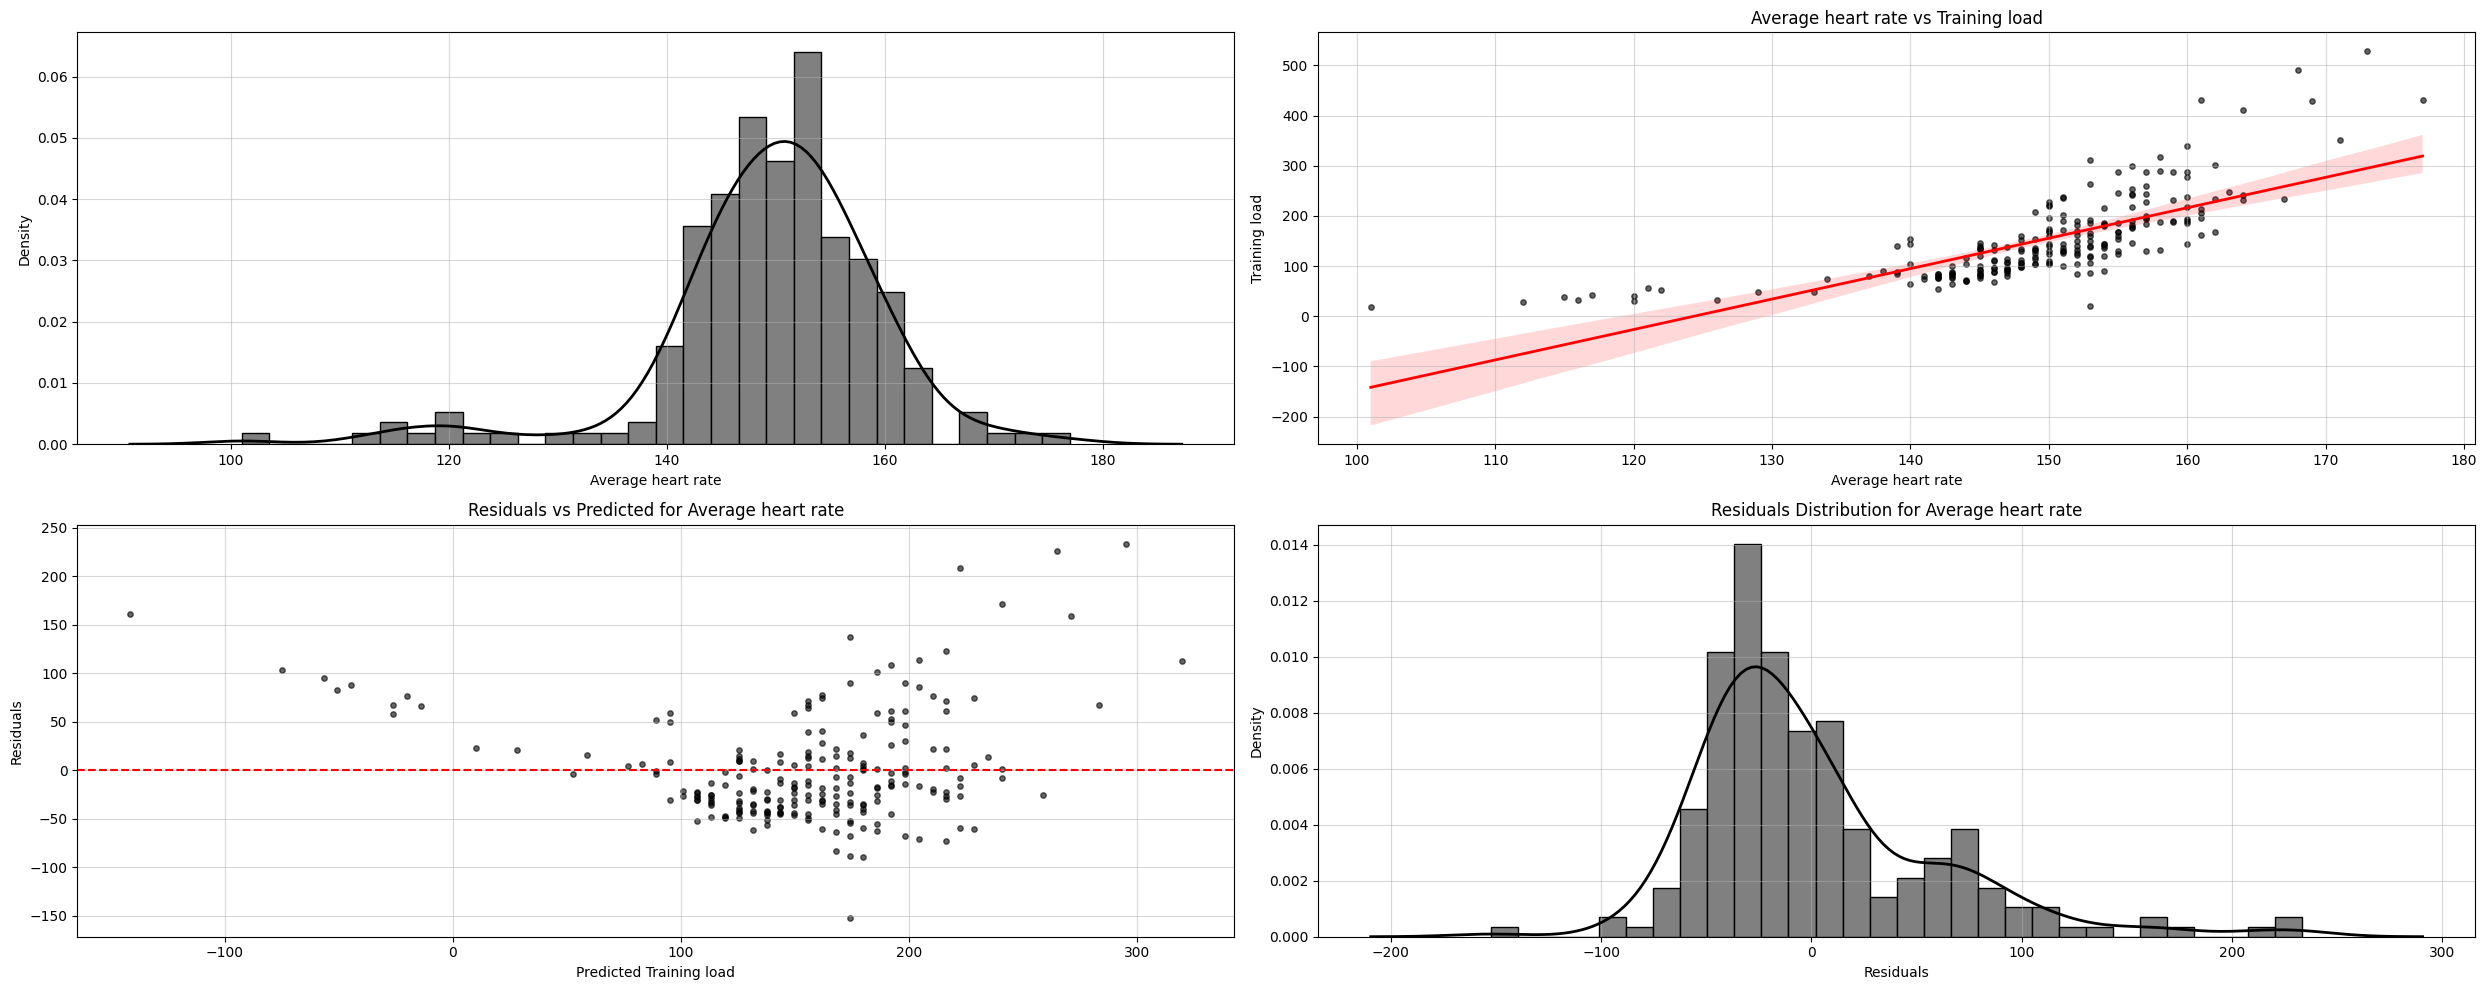

In [732]:
# Average heart rate
metrics_tmp = univariate_LM_training_load_analysis(feature_col="Average heart rate")
training_load_univariate_df = pd.concat([training_load_univariate_df, metrics_tmp], ignore_index=True)

In [733]:
# Check results
training_load_univariate_df.sort_values(by="R2", ascending=False)

,feature,coef,scaled coef,p-value,standard error,scaled standard error,confidence interval,scaled confidence interval,R2,R2 adjusted,MAE,RMSE,Pearson correlation coefficient
1,Distance [km],9.386037,1.408980,3.970218e-42,0.550296,0.082607,"[8.3015, 10.4706]","[1.2462, 1.5718]",0.569403,0.567446,40.516786,54.373211,0.754588
2,Average heart rate,6.065314,0.602664,3.040235e-39,0.375369,0.037297,"[5.3255, 6.8051]","[0.5292, 0.6762]",0.542705,0.540627,41.495431,56.033512,0.736685
0,Duration [h],53.194304,62.682533,1.472199e-18,5.520245,6.504887,"[42.315, 64.0736]","[49.8627, 75.5024]",0.296803,0.293606,52.863492,69.484556,0.544796


---
---

In [734]:
for col in tp_log_df.columns:
    print(col)

Year
Month
Day
Weekday
Description
Activity type
Start time
Location
Distance [km]
Duration [h]
Elevation gain [m]
Average pace [min/km] or speed [km/h]
Gradient adjusted pace [min/km]
Average heart rate
Maximum heart rate
Normalized power [w]
Calories [kcal]
Aerobic training effect
Aerobic training effect message
Anaerobic training effect
Anaerobic training effect message
Training effect label
Training load
Vo2Max value
Time in Z1 [h]
Time in Z2 [h]
Time in Z3 [h]
Time in Z4 [h]
Time in Z5 [h]
10% heart rate [1]
10% heart rate [2]
10% heart rate [3]
10% heart rate [4]
10% heart rate [5]
10% heart rate [6]
10% heart rate [7]
10% heart rate [8]
10% heart rate [9]
10% heart rate [10]
Date
Datetime
Average heart rate [normalized ~ max]
Average heart rate [normalized ~ HRR]
Maximum heart rate [normalized ~ max]
Maximum heart rate [normalized ~ HRR]
10% heart rate [1] [normalized ~ max]
10% heart rate [1] [normalized ~ HRR]
10% heart rate [2] [normalized ~ max]
10% heart rate [2] [normalize

In [735]:
for col in daily_log_df.columns:
    print(col)

Year
Month
Day
Weekday
Resting HR
Sleep score
Sleep time [h]
HRV
HRV baseline lower
HRV baseline upper
Meters ascended [m]
Highly active time [h]
Active time [h]
Sedentary time [h]
vo2Max
Hill score
Endurance score
Low aerobic load
High aerobic load
Anaerobic load
Date
Datetime
HRV normalized


---
---
## Ideas
- Rolling weekly training load - day by day - we see how it goes down before a race and also builds and how does it affect HRV, resting HR etc.